In [30]:
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Normalization,Dense,InputLayer
from tensorflow.keras.losses import MeanSquaredError,Huber, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError

In [2]:
df = pd.read_csv('car price prediction dataset.csv')

In [3]:
df.head()

,v.id,on road old,on road now,years,km,rating,condition,economy,top speed,hp,torque,current price
0,1,535651,798186,3,78945,1,2,14,177,73,123,351318.0
1,2,591911,861056,6,117220,5,9,9,148,74,95,285001.5
2,3,686990,770762,2,132538,2,8,15,181,53,97,215386.0
3,4,573999,722381,4,101065,4,3,11,197,54,116,244295.5
4,5,691388,811335,6,61559,3,9,12,160,53,105,531114.5


In [4]:
df.shape

(1000, 12)

In [5]:
# sns.pairplot(df[['years','km','rating','condition','economy','top speed','hp','torque','current price']],diag_kind = 'kde')

In [6]:
tensor_data = tf.constant(df)
tensor_data = tf.cast(tensor_data,tf.float32)
tensor_data = tf.random.shuffle(tensor_data)
print(tensor_data)

tf.Tensor(
[[1.290000e+02 5.295150e+05 7.292340e+05 ... 9.200000e+01 7.300000e+01
  3.309085e+05]
 [4.150000e+02 5.829500e+05 7.973420e+05 ... 9.600000e+01 1.110000e+02
  1.814145e+05]
 [2.450000e+02 6.912250e+05 8.593000e+05 ... 6.200000e+01 8.200000e+01
  4.779120e+05]
 ...
 [1.790000e+02 6.236270e+05 7.281460e+05 ... 1.190000e+02 1.050000e+02
  3.123235e+05]
 [3.350000e+02 5.533510e+05 7.470140e+05 ... 8.700000e+01 7.000000e+01
  3.159145e+05]
 [5.620000e+02 5.496300e+05 7.868820e+05 ... 6.200000e+01 1.260000e+02
  7.131400e+04]], shape=(1000, 12), dtype=float32)


In [7]:
X = tensor_data[:,3:-1]
y = tensor_data[:,-1]
y = tf.expand_dims(y,axis = -1)

In [8]:
print(X.shape,y.shape)

(1000, 8) (1000, 1)


In [39]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1
DATASET_SIZE = len(X)

In [40]:
X_train = X[:int(DATASET_SIZE*TRAIN_RATIO)]
y_train = y[:int(DATASET_SIZE*TRAIN_RATIO)]
print(X_train.shape)
print(y_train.shape)

(800, 8)
(800, 1)


In [41]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)

In [42]:
X_val = X[int(DATASET_SIZE*TRAIN_RATIO):int(DATASET_SIZE*(TRAIN_RATIO+VAL_RATIO))]
y_val = y[int(DATASET_SIZE*TRAIN_RATIO):int(DATASET_SIZE*(TRAIN_RATIO+VAL_RATIO))]
print(X_val.shape)
print(y_val.shape)

(100, 8)
(100, 1)


In [43]:
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)

In [44]:
X_test = X[int(DATASET_SIZE*(TRAIN_RATIO+VAL_RATIO)):]
y_test = y[int(DATASET_SIZE*(TRAIN_RATIO+VAL_RATIO)):]
print(X_test.shape)
print(y_test.shape)

(100, 8)
(100, 1)


In [45]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)

In [46]:
normalizer = Normalization()
normalizer.adapt(X_train)
normalizer(X)[:5]

<tf.Tensor: shape=(5, 8), dtype=float32, numpy=
array([[ 0.23246732, -0.89892215, -0.7268424 , -0.89581794,  0.62860245,
        -1.1874003 ,  0.36048356, -1.4326832 ],
       [ 1.3984454 ,  1.2672479 , -0.7268424 ,  1.5888685 ,  1.0768036 ,
         1.1418502 ,  0.5567652 ,  0.36371103],
       [ 0.81545633, -0.9255632 ,  0.7018406 , -1.6057284 , -1.1642017 ,
        -0.72155017, -1.1116285 , -1.0072213 ],
       [ 0.23246732,  1.2317492 , -0.7268424 , -0.89581794,  0.18040141,
        -0.15217783,  1.6853844 , -1.3381361 ],
       [ 0.81545633,  1.336501  , -0.7268424 , -1.2507732 , -0.26779965,
        -0.20393895, -1.6023325 ,  0.83644634]], dtype=float32)>

In [47]:
model = tf.keras.Sequential([InputLayer(input_shape = (8,)),
                             normalizer,
                             Dense(128,activation = 'relu'),
                             Dense(128,activation = 'relu'),
                             Dense(128,activation = 'relu'),
                             Dense(1)])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normaliza  (None, 8)                 17        
 tion)                                                           
                                                                 
 dense_5 (Dense)             (None, 128)               1152      
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dense_7 (Dense)             (None, 128)               16512     
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
Total params: 34322 (134.07 KB)
Trainable params: 34305 (134.00 KB)
Non-trainable params: 17 (72.00 Byte)
______________

In [11]:
# tf.keras.utils.plot_model(model,to_file= 'model.png',show_shapes = True)

In [48]:
model.compile(optimizer = Adam(learning_rate = 0.1),
              loss = MeanAbsoluteError(),
             metrics = RootMeanSquaredError())

In [49]:
history = model.fit(train_dataset, validation_data = val_dataset , epochs = 100, verbose = 1)

Epoch 1/100
25/25 [==============================] - 1s 16ms/step - loss: 153153.7188 - root_mean_squared_error: 199725.2500 - val_loss: 61461.9258 - val_root_mean_squared_error: 75412.5156
Epoch 2/100
25/25 [==============================] - 0s 5ms/step - loss: 50742.0664 - root_mean_squared_error: 63395.1758 - val_loss: 39816.7500 - val_root_mean_squared_error: 49559.8516
Epoch 3/100
25/25 [==============================] - 0s 4ms/step - loss: 43111.4297 - root_mean_squared_error: 53914.5352 - val_loss: 40234.4688 - val_root_mean_squared_error: 50143.2891
Epoch 4/100
25/25 [==============================] - 0s 4ms/step - loss: 44154.9531 - root_mean_squared_error: 56498.5977 - val_loss: 37665.6953 - val_root_mean_squared_error: 47049.3125
Epoch 5/100
25/25 [==============================] - 0s 4ms/step - loss: 39885.2969 - root_mean_squared_error: 49889.5742 - val_loss: 39582.0156 - val_root_mean_squared_error: 48876.7383
Epoch 6/100
25/25 [==============================] - 0s 3ms/st

25/25 [==============================] - 0s 4ms/step - loss: 37513.7266 - root_mean_squared_error: 47226.5391 - val_loss: 35050.4883 - val_root_mean_squared_error: 43594.9102
Epoch 45/100
25/25 [==============================] - 0s 3ms/step - loss: 36052.5742 - root_mean_squared_error: 44640.1445 - val_loss: 39430.9336 - val_root_mean_squared_error: 48806.3242
Epoch 46/100
25/25 [==============================] - 0s 3ms/step - loss: 35023.3125 - root_mean_squared_error: 43638.1758 - val_loss: 33728.7539 - val_root_mean_squared_error: 41828.1641
Epoch 47/100
25/25 [==============================] - 0s 3ms/step - loss: 37278.8359 - root_mean_squared_error: 47117.9453 - val_loss: 34991.1289 - val_root_mean_squared_error: 44281.5195
Epoch 48/100
25/25 [==============================] - 0s 4ms/step - loss: 37561.2188 - root_mean_squared_error: 47401.1016 - val_loss: 34696.0156 - val_root_mean_squared_error: 43120.5586
Epoch 49/100
25/25 [==============================] - 0s 4ms/step - loss:

Epoch 88/100
25/25 [==============================] - 0s 4ms/step - loss: 33844.4805 - root_mean_squared_error: 43001.5195 - val_loss: 38889.4219 - val_root_mean_squared_error: 48382.2891
Epoch 89/100
25/25 [==============================] - 0s 4ms/step - loss: 35744.9844 - root_mean_squared_error: 45685.7070 - val_loss: 46536.6719 - val_root_mean_squared_error: 57396.2266
Epoch 90/100
25/25 [==============================] - 0s 4ms/step - loss: 40055.0703 - root_mean_squared_error: 50320.3555 - val_loss: 36798.0586 - val_root_mean_squared_error: 45474.2617
Epoch 91/100
25/25 [==============================] - 0s 4ms/step - loss: 37062.1953 - root_mean_squared_error: 46949.8398 - val_loss: 30838.5000 - val_root_mean_squared_error: 38858.6758
Epoch 92/100
25/25 [==============================] - 0s 3ms/step - loss: 33166.0234 - root_mean_squared_error: 41776.7344 - val_loss: 33006.0117 - val_root_mean_squared_error: 41395.4219
Epoch 93/100
25/25 [==============================] - 0s 4ms

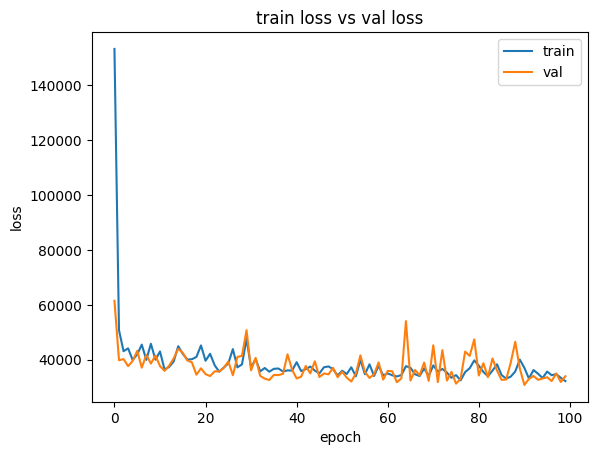

In [52]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('train loss vs val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

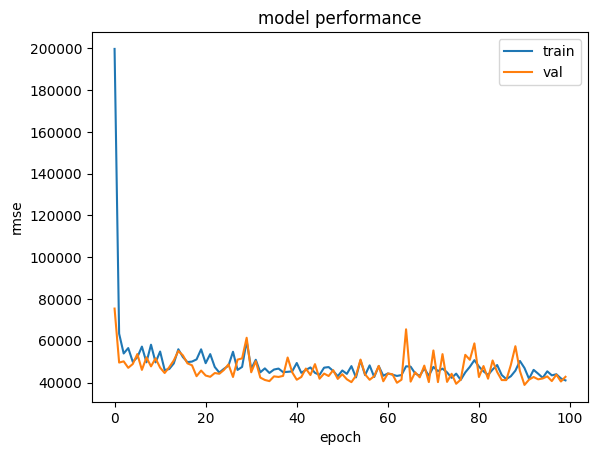

In [51]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model performance')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

In [54]:
model.evaluate(X_test,y_test)

4/4 [==============================] - 0s 6ms/step - loss: 43692.2461 - root_mean_squared_error: 52460.8750


[43692.24609375, 52460.875]

In [57]:
y_true = list(y_test[:,0].numpy())
print(y_true)

[387089.0, 224745.0, 108894.0, 443423.0, 498712.0, 326161.5, 343595.0, 528418.5, 103742.5, 254581.0, 491123.0, 334502.0, 352284.5, 208573.5, 230080.0, 164649.5, 443528.0, 192853.5, 273674.5, 122225.5, 77167.0, 489368.0, 218665.5, 245594.5, 379566.0, 378071.5, 302929.5, 301042.5, 420083.0, 172234.5, 240353.5, 201073.0, 216831.5, 333278.0, 360737.5, 451290.0, 441865.0, 382241.0, 456154.5, 405505.0, 53040.0, 287588.5, 538075.5, 193067.0, 450198.5, 309449.0, 232718.5, 467471.5, 423584.0, 165595.0, 140884.0, 160150.5, 429669.0, 362434.5, 496293.5, 422439.5, 350647.5, 398998.0, 302878.5, 90220.0, 330281.5, 174352.5, 439166.0, 275045.5, 469956.0, 306660.0, 304354.0, 150234.5, 153991.0, 508432.0, 265799.5, 427132.5, 414035.0, 494575.5, 547746.0, 367122.0, 295553.5, 490000.5, 245796.0, 207352.5, 177748.5, 283184.0, 164382.0, 248119.5, 301081.5, 130233.5, 341076.0, 355175.0, 276805.5, 459095.0, 239746.0, 200794.5, 109828.5, 156513.0, 172462.0, 167794.0, 327994.0, 312323.5, 315914.5, 71314.0]


In [58]:
y_pred = list(model.predict(X_test)[:,0])
print(y_pred)

4/4 [==============================] - 0s 3ms/step
[396034.72, 205241.77, 105237.36, 393596.25, 411365.34, 358746.34, 315665.5, 497891.22, 136442.98, 136906.64, 454596.2, 265807.72, 340648.66, 188732.97, 251081.89, 164657.73, 408601.72, 162149.89, 212005.94, 187228.12, 153074.98, 406434.56, 196789.0, 210933.38, 290400.03, 326673.88, 217873.34, 286080.8, 327204.47, 157204.22, 189769.9, 216771.14, 233305.0, 286834.22, 387005.4, 498871.1, 352493.53, 405868.03, 475666.47, 444503.78, 108618.74, 288386.03, 486882.53, 223605.97, 380898.53, 248661.61, 204417.5, 343152.94, 364434.8, 171264.4, 171123.53, 154737.97, 451993.3, 245736.27, 517998.78, 398669.28, 374158.84, 363641.62, 304747.47, 199365.39, 299990.1, 91659.22, 424585.1, 209576.45, 485508.1, 234365.78, 219239.69, 151808.16, 160422.02, 488725.28, 200055.23, 371565.78, 369066.16, 443222.06, 450494.6, 305846.25, 227084.83, 415946.34, 174416.17, 159467.6, 138371.14, 310773.62, 178519.36, 214933.06, 255428.38, 192455.84, 368979.38, 358747.56

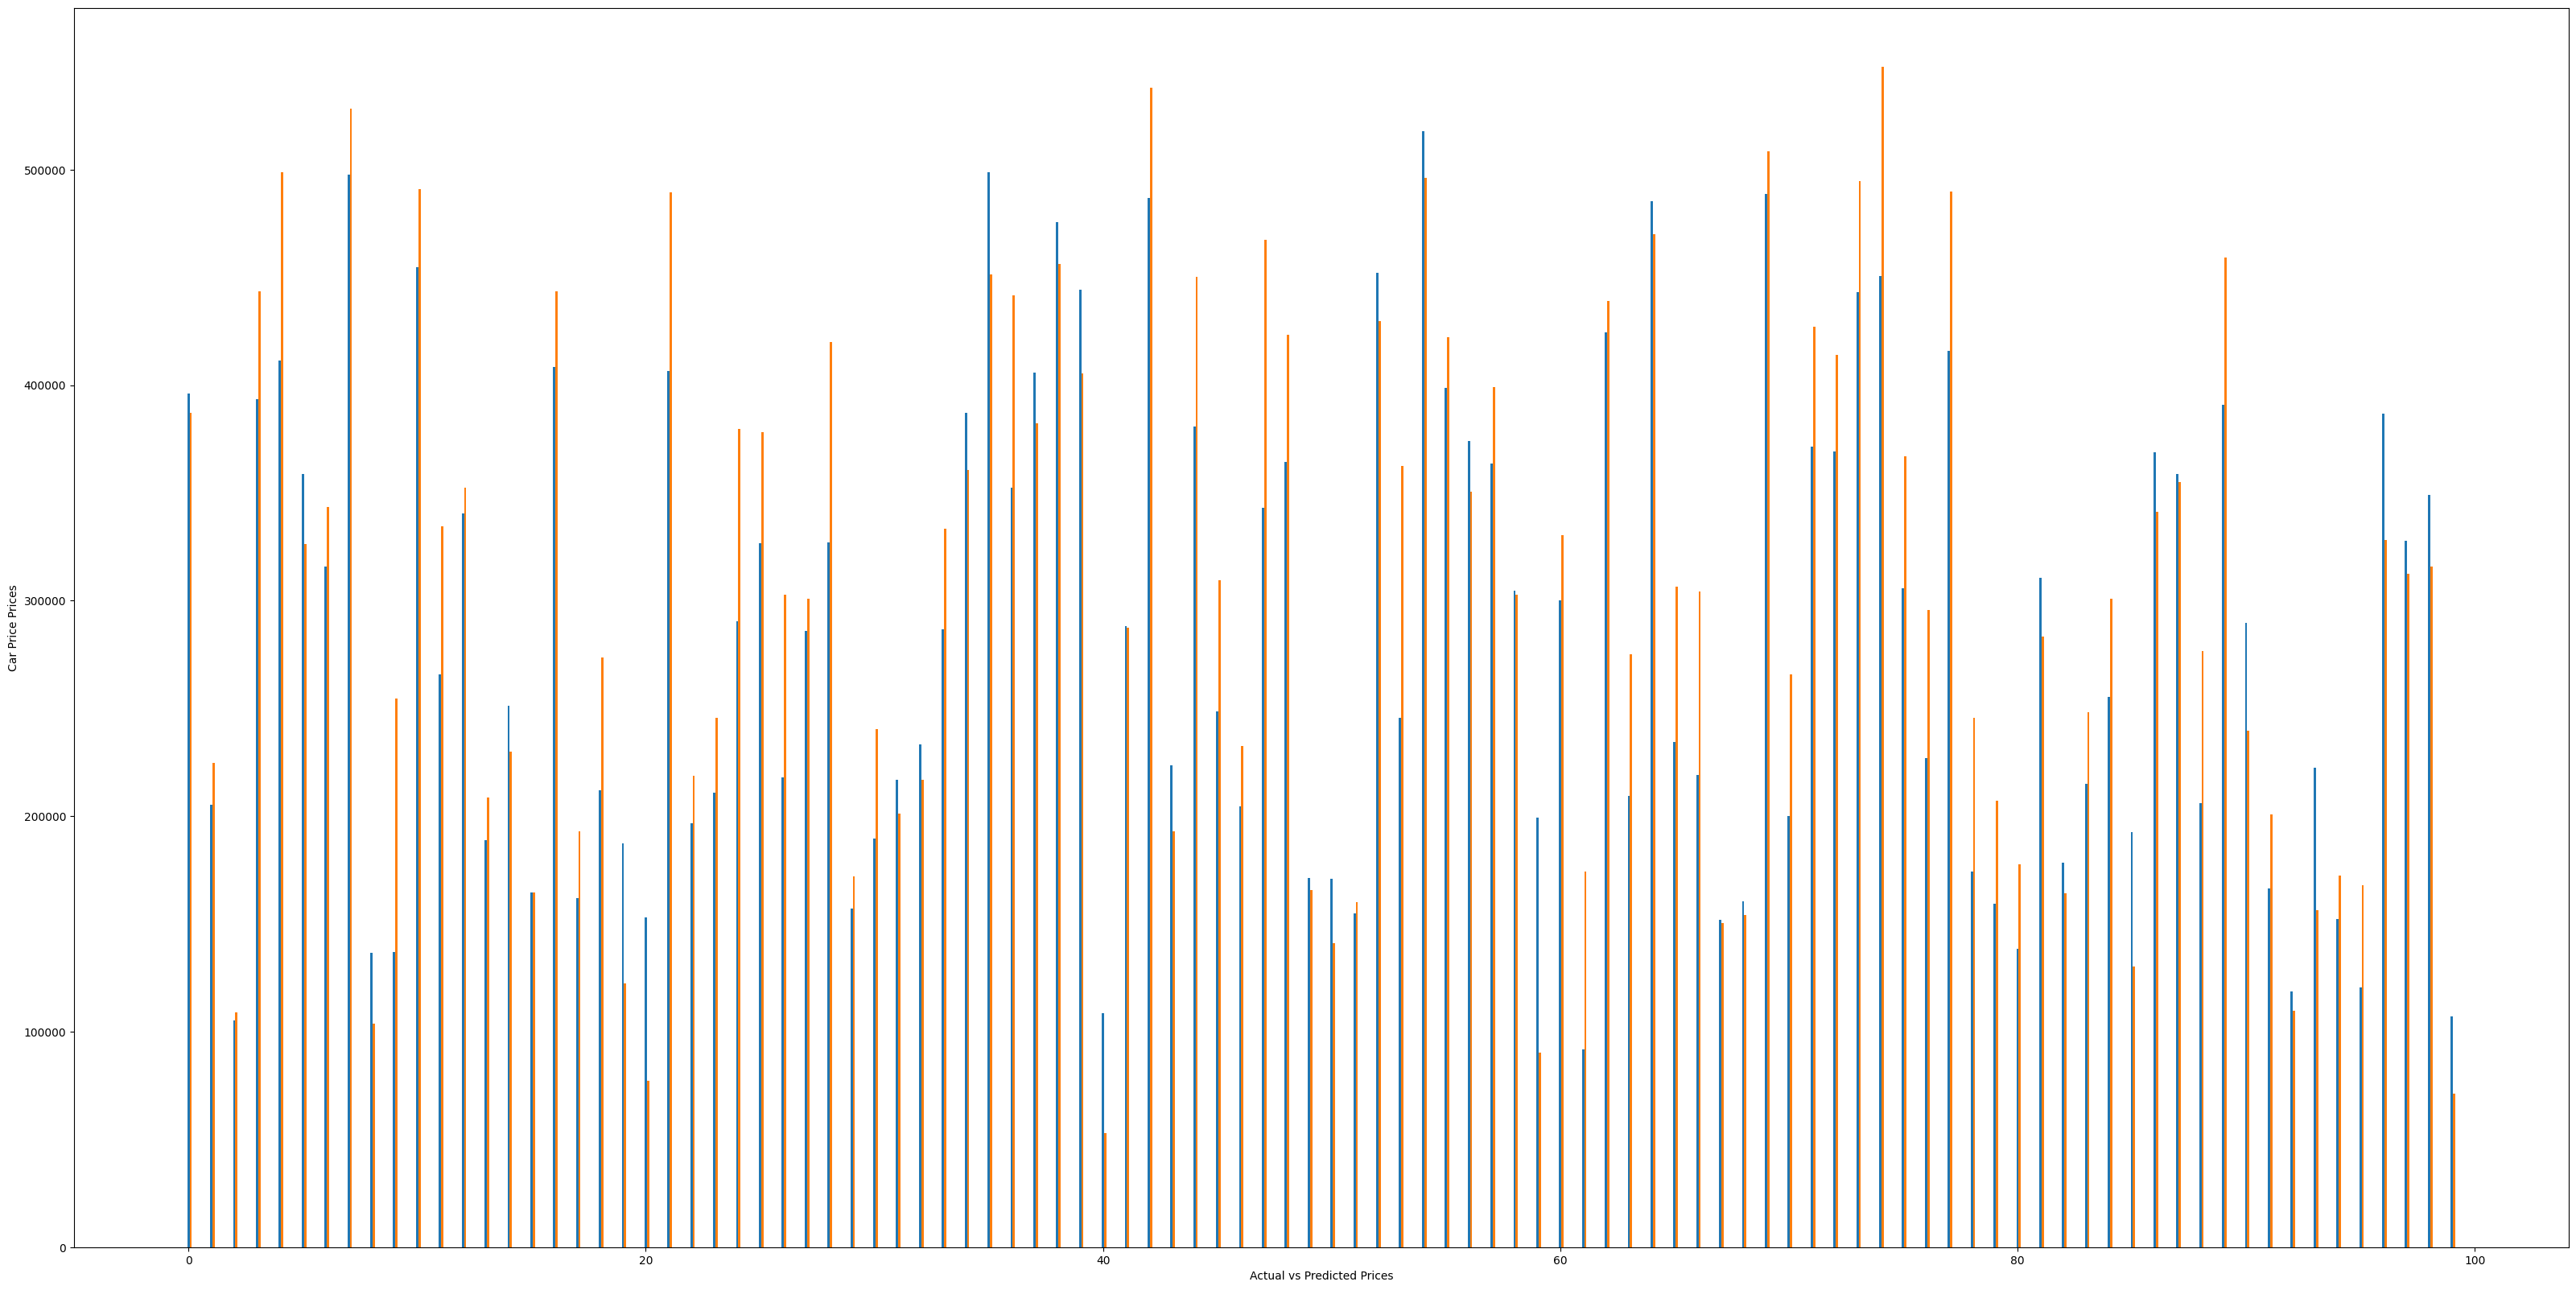

In [60]:
import numpy as np
ind = np.arange(100)
plt.figure(figsize=(40,20))

width = 0.1

plt.bar(ind, y_pred, width, label='Predicted Car Price')
plt.bar(ind + width, y_true, width, label='Actual Car Price')

plt.xlabel('Actual vs Predicted Prices')
plt.ylabel('Car Price Prices')

plt.show()